In [35]:
# Import relevant packages 
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [13]:
ohe = OneHotEncoder(sparse=False)
scaler = StandardScaler()
pca = PCA()

In [3]:
df = pd.read_csv('data/twm_customer.csv',sep=';')

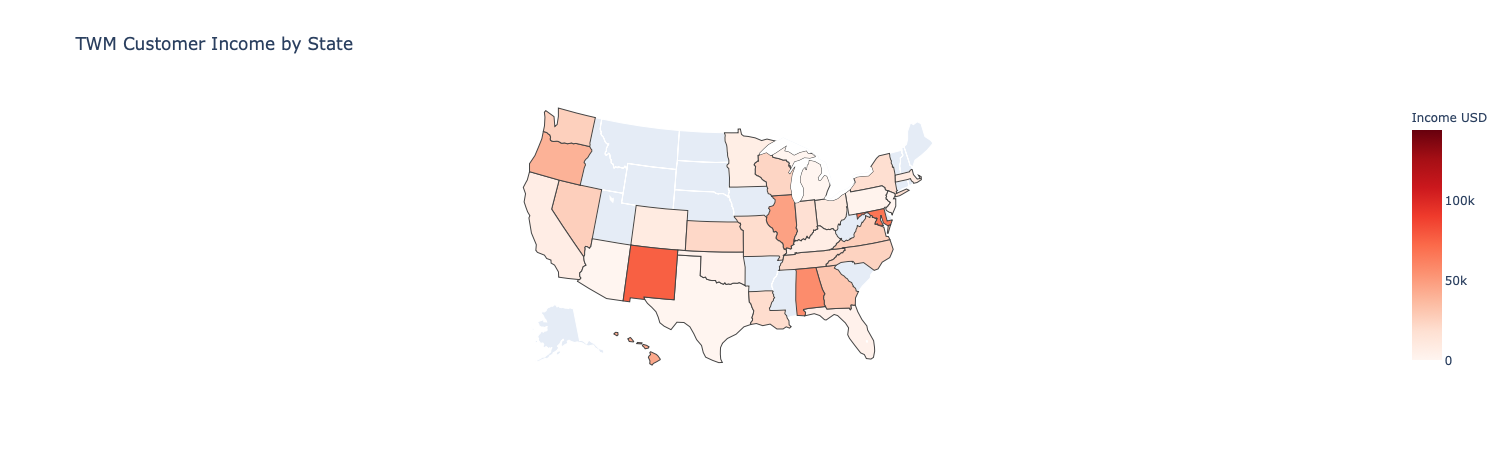

In [4]:
state_list = ['NV', 'CA', 'NY', 'IL', 'HI', 'DC', 'TX', 'PA', 'OR', 'OH', 'WA', 'NJ', 'IN', 'CO', 'WI', 'MI', 'NB', 'AZ', 'MN', 'TN', 'VA', 'FL', 'MD', 'MO', 'LA', 'KY', 'OK', 'MA',
'GA', 'KS', 'NC', 'NM', 'AL']
fig = go.Figure(data=go.Choropleth(
    locations=state_list, # Spatial coordinates
    z = df['income'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Income USD",
))

fig.update_layout(
    title_text = 'TWM Customer Income by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

In [5]:
state_labels = {st : i for i, st in enumerate(df.state_code.unique())} # dictionary comprehension for statecode re-labeling
df= df.replace({'gender': {'M ': 0, 'F ': 1},'state_code': state_labels }) # replace gender strings with binary values, replace state code with labels
marital_status_df = pd.DataFrame(ohe.fit_transform(df[['marital_status']]),  dtype='int64') # one hot encode values for marital status
df = df.drop(columns=['cust_id','first_name','last_name','name_prefix','street_nbr','street_name','postal_code','city_name','marital_status']) # drop unnecessary columns

In [6]:
df = pd.concat([df, marital_status_df], axis=1)

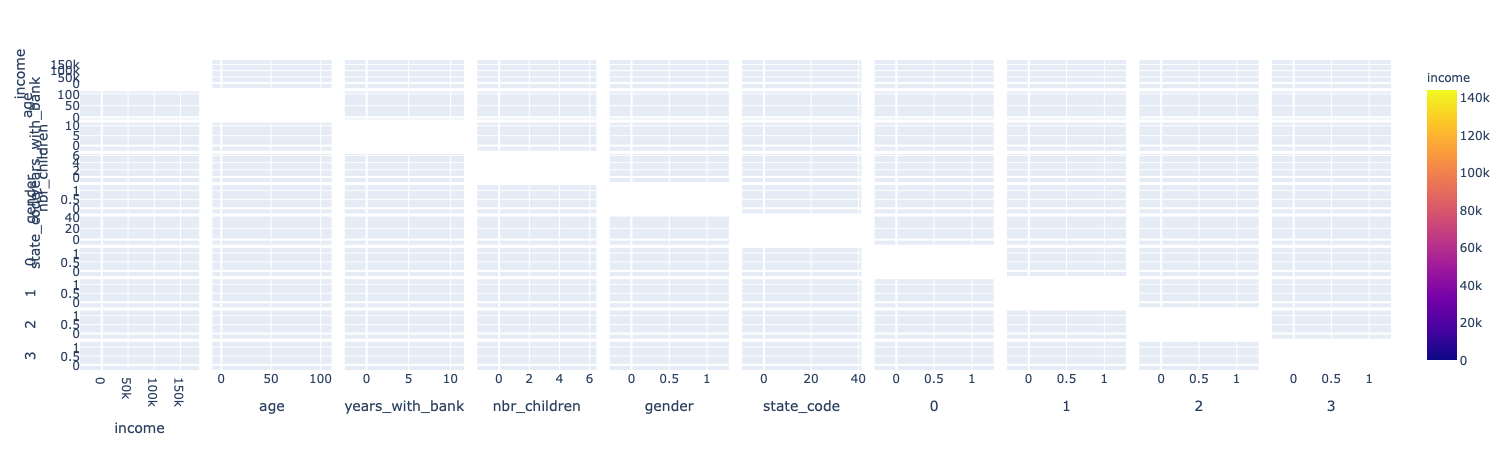

In [8]:
features = list(df.columns)

fig = px.scatter_matrix(
    df,
    dimensions=features,
    color="income"
)
fig.update_traces(diagonal_visible=False)
fig.show()

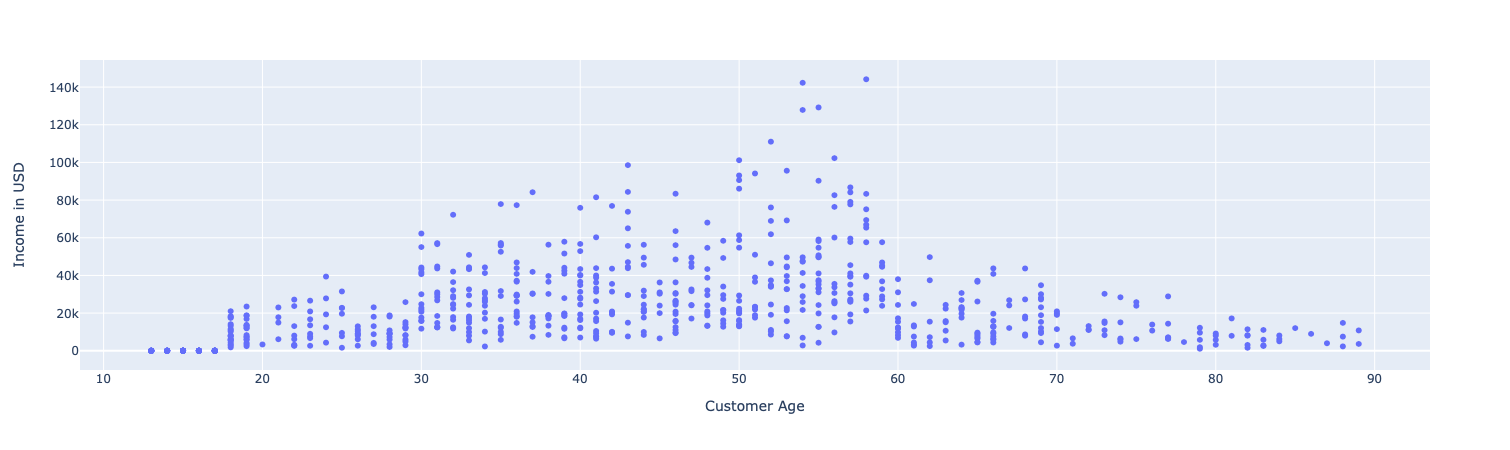

In [9]:
fig = px.scatter(df, x='age',y='income',labels={'income':'Income in USD', 'age': 'Customer Age'})
fig.show()

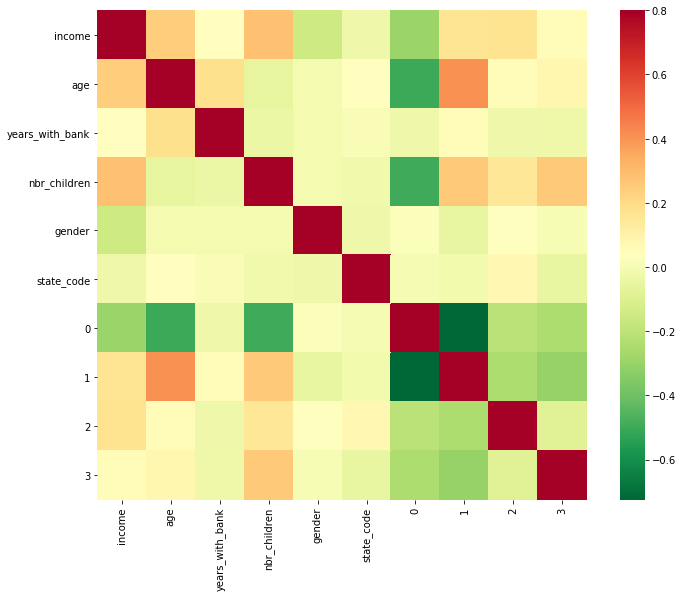

In [36]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="RdYlGn_r")

In [14]:
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df

income       age  years_with_bank  nbr_children    gender  state_code  \
0    0.154185  0.184312         0.408539      0.258591 -1.127172   -0.982716   
1   -0.726524  1.493070        -1.087435     -0.648298 -1.127172   -0.867020   
2   -0.188366 -0.234490         1.530520     -0.648298  0.887176   -0.867020   
3    1.123798  0.603115        -0.339448     -0.648298  0.887176   -0.867020   
4    0.983479  0.864867         1.904514      1.165479  0.887176   -0.751325   
..        ...       ...              ...           ...       ...         ...   
742 -0.357478 -0.339191         0.782533      0.258591  0.887176   -0.867020   
743  0.164864  0.707816         0.782533      0.258591 -1.127172   -0.751325   
744  1.738064  0.393714        -1.461429      1.165479 -1.127172    2.603849   
745 -0.343735 -0.286841         1.156526     -0.648298  0.887176    2.719545   
746 -0.218692 -1.281497        -0.339448     -0.648298  0.887176   -0.867020   

            0         1         2         3  
0   -0.765498  1.056479 -0.262049 -0.321555  
1   -0.765498  1.056479 -0.262049 -0.321555  
2    1.306339 -0.946541 -0.262049 -0.321555  
3    1.306339 -0.946541 -0.262049 -0.321555  
4   -0.765498 -0.946541 -0.262049  3.109892  
..        ...       ...       ...       ...  
742 -0.765498 -0.946541 -0.262049  3.109892  
743 -0.765498  1.056479 -0.262049 -0.321555  
744 -0.765498  1.056479 -0.262049 -0.321555  
745 -0.765498  1.056479 -0.262049 -0.321555  
746  1.306339 -0.946541 -0.262049 -0.321555  

[747 rows x 10 columns]

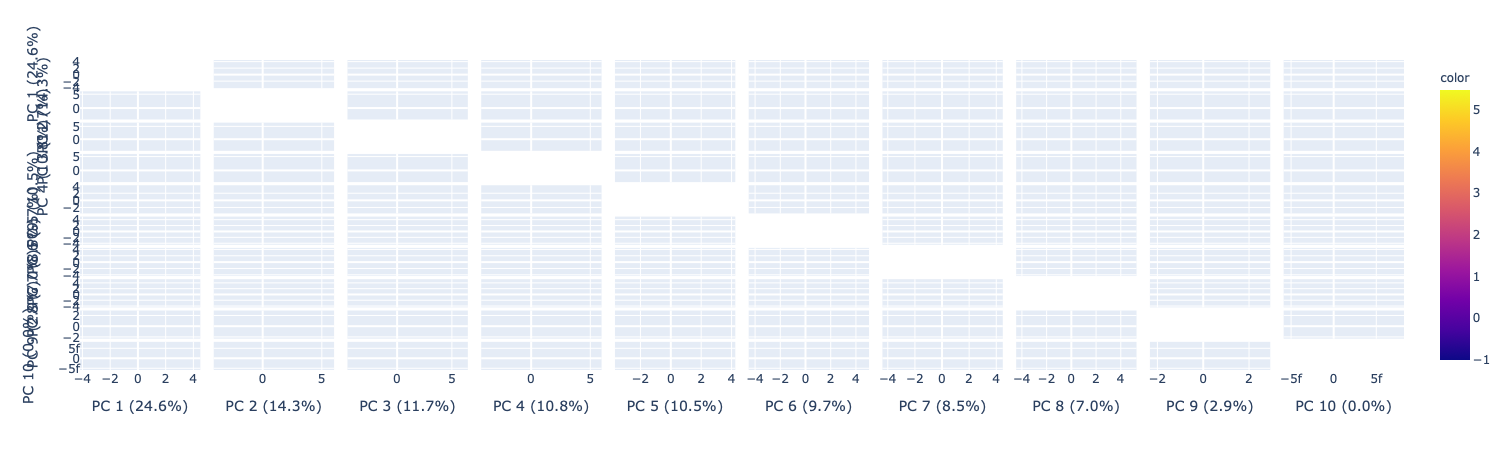

In [18]:
principal_components = pca.fit_transform(scaled_df)
labels = { str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)}
fig = px.scatter_matrix(
    principal_components, labels=labels, dimensions=range(10), color=scaled_df['income'])
fig.update_traces(diagonal_visible=False)
fig.show()

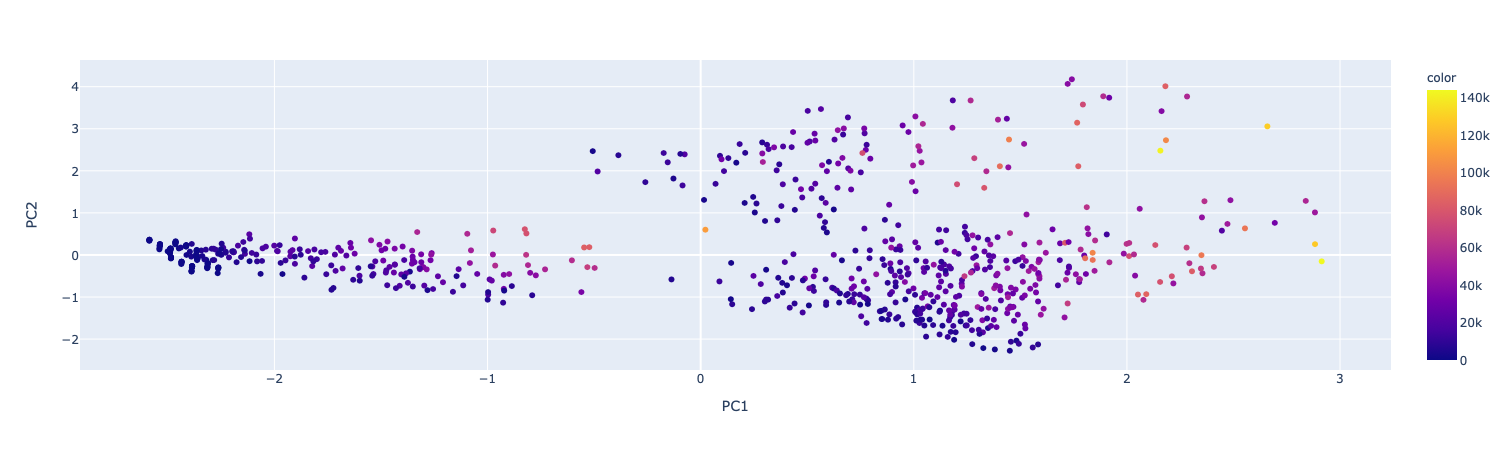

In [30]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_df)
labels = {
    'x':'PC1', 'y':'PC2'
}
fig = px.scatter(
    x = components[:, 0],
    y = components[:, 1],
    color=df['income'],
    labels=labels
)
# fig.update_traces(diagonal_visible=False)
fig.show()

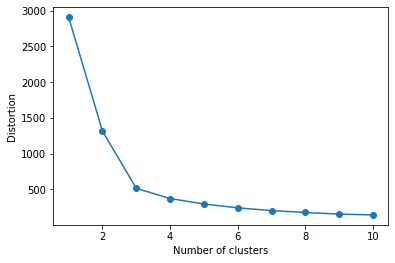

In [32]:
# elbow rule
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

plot_distortion(components)

In [39]:
km = KMeans(n_clusters=3, n_init=10)
y_res = km.fit_predict(components)

In [48]:
plt.rcParams["figure.figsize"] = (12,8)

In [49]:
 def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []
    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))
        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')
    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

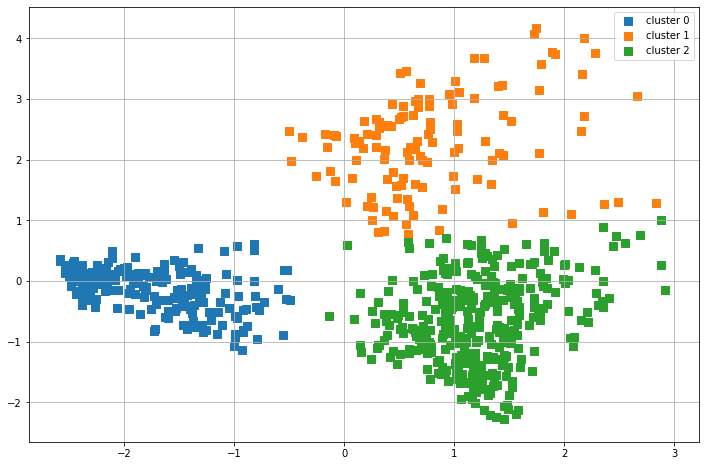

In [50]:
plot_clusters(components,y_res)